### 1. Import libraries

In [146]:
# Data preprocessing libraries
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

import os
import sqlite3
import math
from collections import Counter
from pathlib import Path
from tqdm import tqdm

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Model
from scipy.stats import skew
import yellowbrick
import sklearn
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Config
mpl.rcParams['font.family'] = 'monospace' 
sns.set_theme(style="white", palette=None)
plotly.offline.init_notebook_mode() 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [147]:
%matplotlib inline

### 2. Data preprocessing

In [148]:
# Reading csv files and drop the first column
df_train = pd.read_csv(r"../input/fraud-detection/fraudTrain.csv")
df_train.drop(df_train.columns[0], axis=1, inplace=True)

df_test = pd.read_csv(r"../input/fraud-detection/fraudTest.csv")
df_test.drop(df_test.columns[0], axis=1, inplace=True)

# First view 10 rows
df_train.head(10)

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   
5   2019-01-01 00:04:08  4767265376804500    fraud_Stroman, Hudson and Erdman   
6   2019-01-01 00:04:42    30074693890476               fraud_Rowe-Vandervort   
7   2019-01-01 00:05:08  6011360759745864                fraud_Corwin-Collins   
8   2019-01-01 00:05:18  4922710831011201                    fraud_Herzog Ltd   
9   2019-01-01 00:06:01  2720830304681674   fraud_Schoen, Kuphal and Nitzsche   

        category     amt      first      last gender  \
0       misc_net    4.97   Jennifer     Banks      F   
1    grocery_pos  107.23  Stephanie      Gill      F   
2  entertainment  220.11     Edward   Sanchez      M   
3  gas_transport   45.00     Jeremy     White      M   
4       misc_pos   41.96      Tyler    Garcia      M   
5  gas_transport   94.63   Jennifer    Conner      F   
6    grocery_net   44.54     Kelsey  Richards      F   
7  gas_transport   71.65     Steven  Williams      M   
8       misc_pos    4.27    Heather     Chase      F   
9    grocery_pos  198.39    Melissa   Aguilar      F   

                           street            city  ...      lat      long  \
0                  561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1    43039 Riley Greens Suite 393          Orient  ...  48.8878 -118.2105   
2        594 White Dale Suite 530      Malad City  ...  42.1808 -112.2620   
3     9443 Cynthia Court Apt. 038         Boulder  ...  46.2306 -112.1138   
4                408 Bradley Rest        Doe Hill  ...  38.4207  -79.4629   
5               4655 David Island          Dublin  ...  40.3750  -75.2045   
6     889 Sarah Station Suite 624         Holcomb  ...  37.9931 -100.9893   
7       231 Flores Pass Suite 720        Edinburg  ...  38.8432  -78.6003   
8     6888 Hicks Stream Suite 954           Manor  ...  40.3359  -79.6607   
9  21326 Taylor Squares Suite 708     Clarksville  ...  36.5220  -87.3490   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   
5      2158                  Transport planner  1961-06-19   
6      2691                    Arboriculturist  1993-08-16   
7      6018               Designer, multimedia  1947-08-21   
8      1472          Public affairs consultant  1941-03-07   
9    151785                        Pathologist  1974-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   
5  189a841a0a8ba03058526bcfe566aab5  1325376248  40.653382  -76.152667   
6  83ec1cc84142af6e2acf10c44949e720  1325376282  37.162705 -100.153370   
7  6d294ed2cc447d2c71c7171a3d54967c  1325376308  38.948089  -78.540296   
8  fc28024ce480f8ef21a32d64c93a29f5  1325376318  40.351813  -79.958146   
9  3b9014ea8fb80bd65de0b1463b00b00e  1325376361  37.179198  -87.485381   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9      

> **Rename some columns**

In [149]:
df_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [150]:
df_train.rename(columns={"trans_date_trans_time":"transaction_time",
                         "cc_num":"credit_card_number",
                         "amt":"amount(usd)",
                         "trans_num":"transaction_id"},
                inplace=True)

> **Convert datetime columns**   
*transaction_time* and *dob* should be in pd.datetime format and we also convert unix_time to exact timestamp

In [151]:
df_train["transaction_time"] = pd.to_datetime(df_train["transaction_time"], infer_datetime_format=True)
df_train["dob"] = pd.to_datetime(df_train["dob"], infer_datetime_format=True)

In [152]:
from datetime import datetime

# Apply function utcfromtimestamp and drop column unix_time
df_train['time'] = df_train['unix_time'].apply(datetime.utcfromtimestamp)
df_train.drop('unix_time', axis=1)

# Add cloumn hour of day
df_train['hour_of_day'] = df_train.time.dt.hour

In [153]:
df_train[['time','hour_of_day']]

time  hour_of_day
0       2012-01-01 00:00:18            0
1       2012-01-01 00:00:44            0
2       2012-01-01 00:00:51            0
3       2012-01-01 00:01:16            0
4       2012-01-01 00:03:06            0
...                     ...          ...
1296670 2013-06-21 12:12:08           12
1296671 2013-06-21 12:12:19           12
1296672 2013-06-21 12:12:32           12
1296673 2013-06-21 12:13:36           12
1296674 2013-06-21 12:13:37           12

[1296675 rows x 2 columns]

> **Convert dtypes**   
Credit card number should be integer, let's change.

In [154]:
# Change dtypes
df_train.credit_card_number = df_train.credit_card_number.astype('category')
df_train.is_fraud = df_train.is_fraud.astype('category')
df_train.hour_of_day = df_train.hour_of_day.astype('category')

# Check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   transaction_time    1296675 non-null  datetime64[ns]
 1   credit_card_number  1296675 non-null  category      
 2   merchant            1296675 non-null  object        
 3   category            1296675 non-null  object        
 4   amount(usd)         1296675 non-null  float64       
 5   first               1296675 non-null  object        
 6   last                1296675 non-null  object        
 7   gender              1296675 non-null  object        
 8   street              1296675 non-null  object        
 9   city                1296675 non-null  object        
 10  state               1296675 non-null  object        
 11  zip                 1296675 non-null  int64         
 12  lat                 1296675 non-null  float64       
 13  long        

### 3. Exploratory Data Analysis

In [155]:
np.round(df_train.describe(), 2)

amount(usd)         zip         lat        long    city_pop  \
count   1296675.00  1296675.00  1296675.00  1296675.00  1296675.00   
mean         70.35    48800.67       38.54      -90.23    88824.44   
std         160.32    26893.22        5.08       13.76   301956.36   
min           1.00     1257.00       20.03     -165.67       23.00   
25%           9.65    26237.00       34.62      -96.80      743.00   
50%          47.52    48174.00       39.35      -87.48     2456.00   
75%          83.14    72042.00       41.94      -80.16    20328.00   
max       28948.90    99783.00       66.69      -67.95  2906700.00   

          unix_time   merch_lat  merch_long  
count  1.296675e+06  1296675.00  1296675.00  
mean   1.349244e+09       38.54      -90.23  
std    1.284128e+07        5.11       13.77  
min    1.325376e+09       19.03     -166.67  
25%    1.338751e+09       34.73      -96.90  
50%    1.349250e+09       39.37      -87.44  
75%    1.359385e+09       41.96      -80.24  
max    1.371817e+09       67.51      -66.95

> Quick Summarize using pandas_profiling

In [156]:
groups = [pd.Grouper(key="transaction_time", freq="1W"), "is_fraud"]
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

In [157]:
def add_traces(df, x, y,hue, mode, cmap, showlegend=None):
    name_map = {1:"Yes", 0:"No"}
    traces = []
    for flag in df[hue].unique():
        traces.append(
            go.Scatter(
                x=df[df[hue]==flag][x],
                y=df[df[hue]==flag][y],
                mode=mode,
                marker=dict(color=cmap[flag]),
                showlegend=showlegend,
                name=name_map[flag]
            )
        )
    return traces

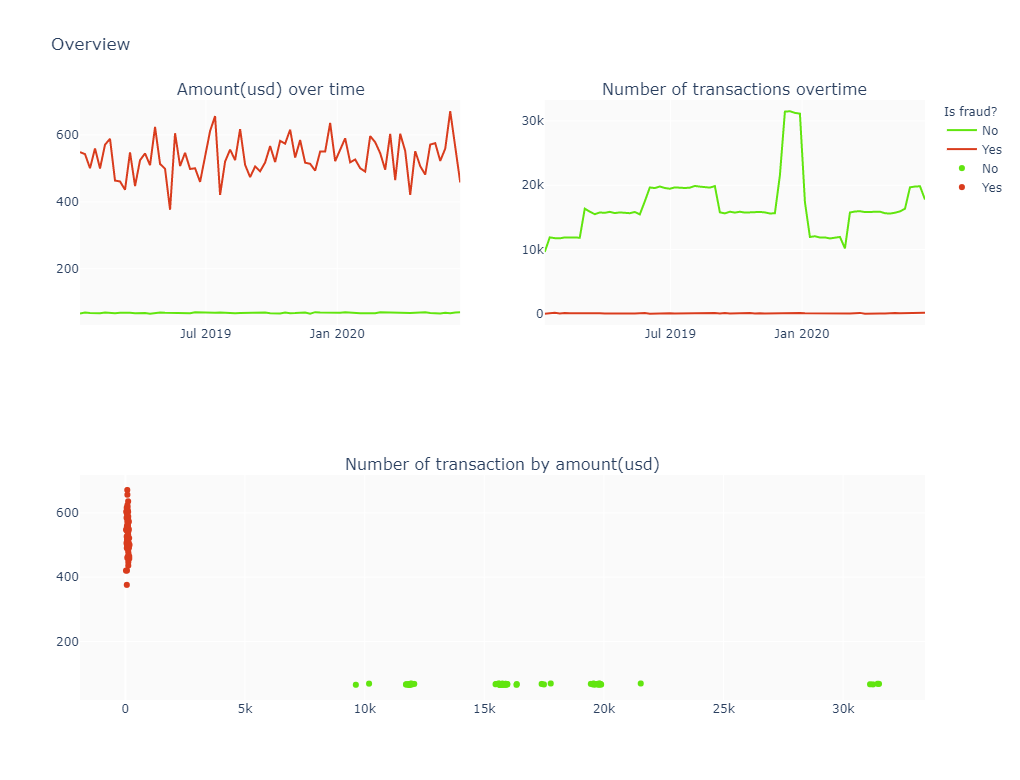

In [158]:
fig = make_subplots(rows=2, cols=2,
                    specs=[
                        [{}, {}],
                        [{"colspan":2}, None]
                    ],
                    subplot_titles=("Amount(usd) over time", "Number of transactions overtime",
                                    "Number of transaction by amount(usd)")
                   )

ntraces = add_traces(df=df_,x='transaction_time',y='amount(usd)',hue='is_fraud',mode='lines',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])

for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=1
    )
    
ntraces = add_traces(df=df_,x='transaction_time',y='transaction_id',hue='is_fraud',mode='lines',
                    showlegend=False, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=2
    )

ntraces = add_traces(df=df_,x='transaction_id',y='amount(usd)',hue='is_fraud',mode='markers',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=2,col=1
    )

fig.update_layout(height=780,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa',
                  title='Overview'
                 )

fig.show()

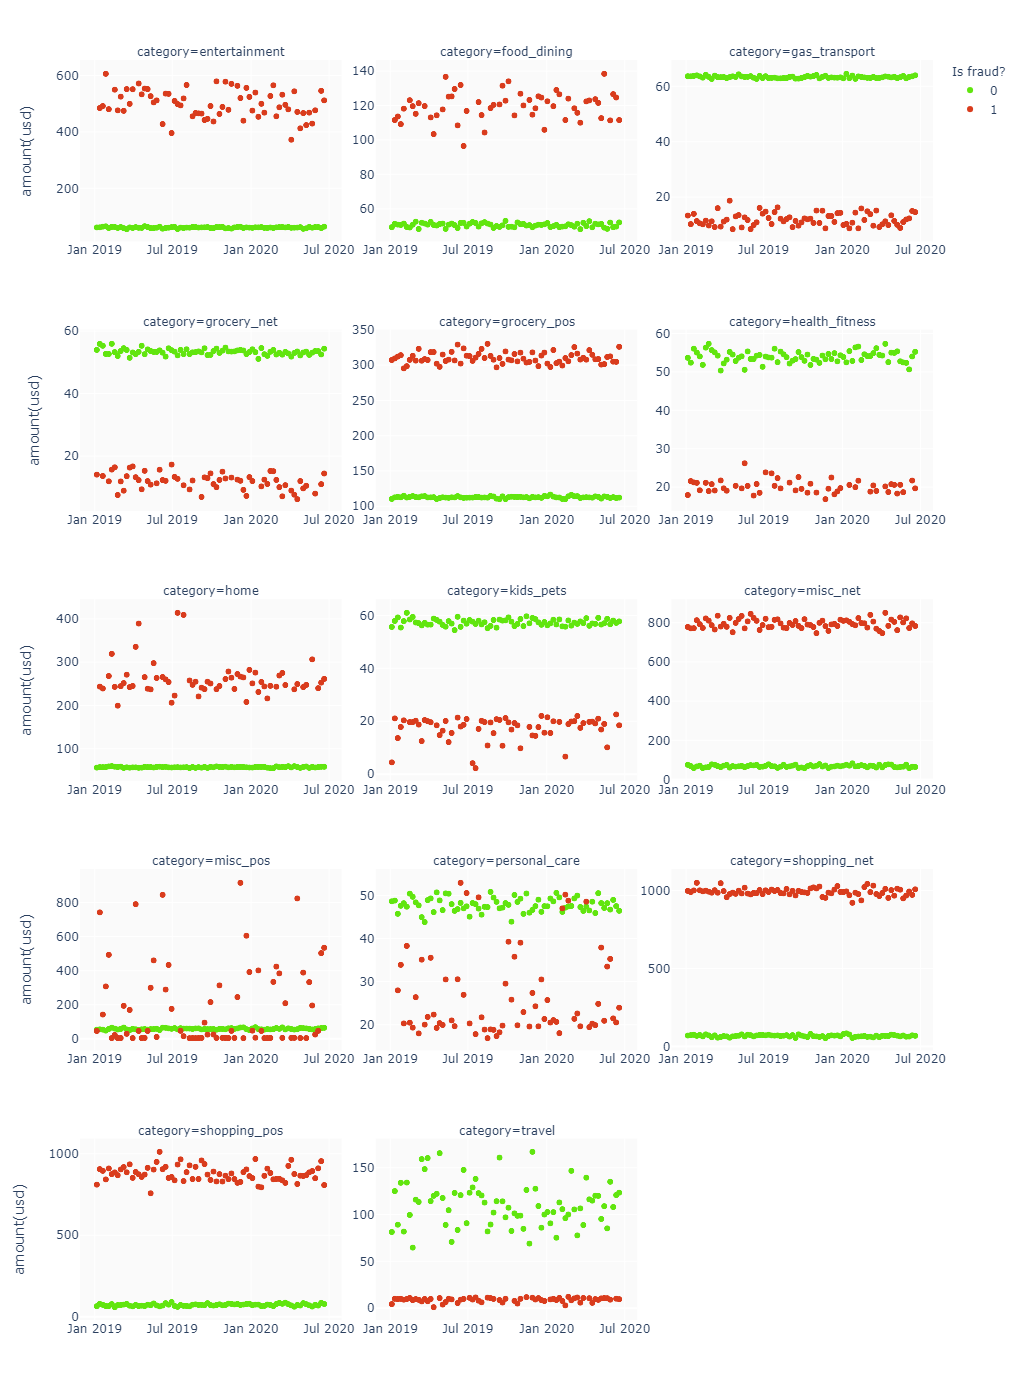

In [159]:
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),
                           'is_fraud','category']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='category',
        facet_col_wrap=3,
        facet_col_spacing=.04,
        color_discrete_map={0:'#61E50F', 1:'#D93C1D'}
)

fig.update_layout(height=1400,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )

fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))

fig.show();

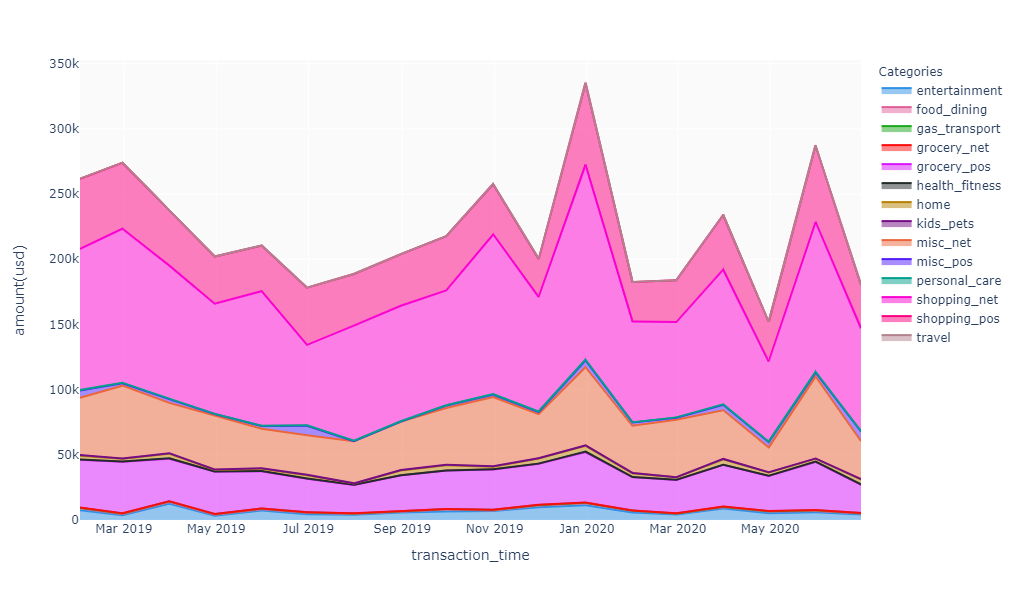

In [160]:
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1M"),
                           'is_fraud','category']).agg({"amount(usd)":'sum',"transaction_id":"count"}).reset_index()

fig = px.area(
    df_[df_.is_fraud==1],
    x='transaction_time',
    y='amount(usd)',
    color='category',
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(height=600,
                  width=960,
                  legend=dict(title='Categories'),
                  plot_bgcolor='#fafafa'
                 )

fig.show();

In [161]:
# Specified list of 12 merchants with the highest number of transactions.
top12_merchants = df_train.merchant.value_counts()[:12]

df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),'is_fraud',
                           'merchant']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

df_ = df_[df_.merchant.isin(top12_merchants.index)]

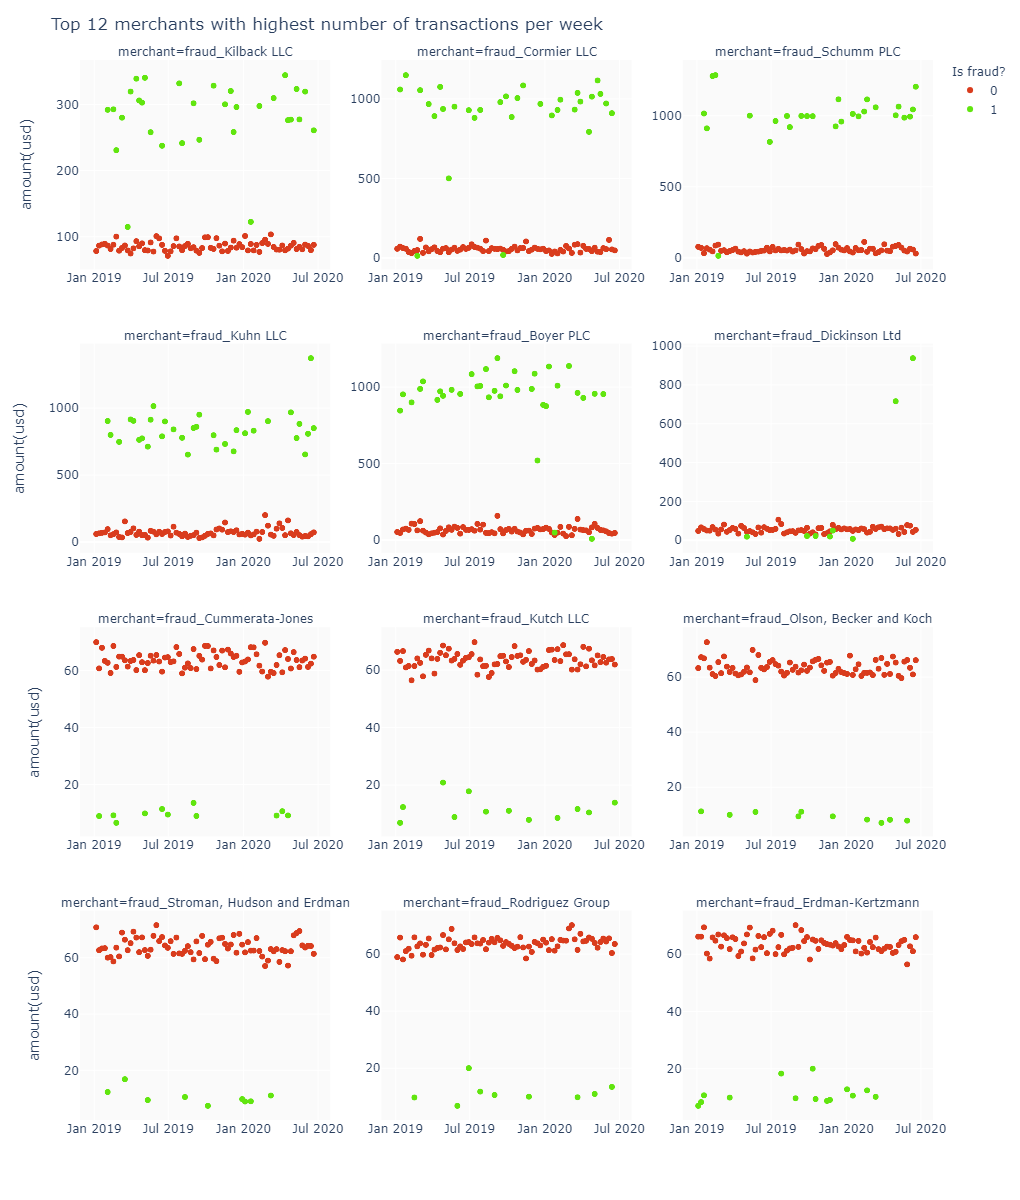

In [162]:
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='merchant',
        facet_col_wrap=3,
        facet_col_spacing=.06,
        category_orders={'merchant': top12_merchants.index}, # order the subplots
        color_discrete_map={1:'#61E50F', 0:'#D93C1D'}
)

fig.update_layout(height=1200,
                  width=960,
                  title='Top 12 merchants with highest number of transactions per week',
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )

fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))

fig.show();

2. Which jobs has most fraud transactions?

In [163]:
groups = ['is_fraud','job']
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()

# Top 10 jobs had most fraud transactions.
df_ = df_[df_.is_fraud==1].sort_values(by='transaction_id',
                                       ascending=False).drop_duplicates('job', keep='first').iloc[:10, :]
df_

is_fraud                        job  amount(usd)  transaction_id
780        1         Materials engineer   561.092097              62
971        1  Trading standards officer   478.137143              56
802        1            Naval architect   653.563962              53
681        1        Exhibition designer   524.067255              51
933        1   Surveyor, land/geomatics   510.914800              50
781        1        Mechanical engineer   531.585714              49
845        1             Prison officer   453.897500              48
875        1          Quantity surveyor   591.754167              48
536        1     Audiological scientist   660.311739              46
604        1    Copywriter, advertising   458.743556              45

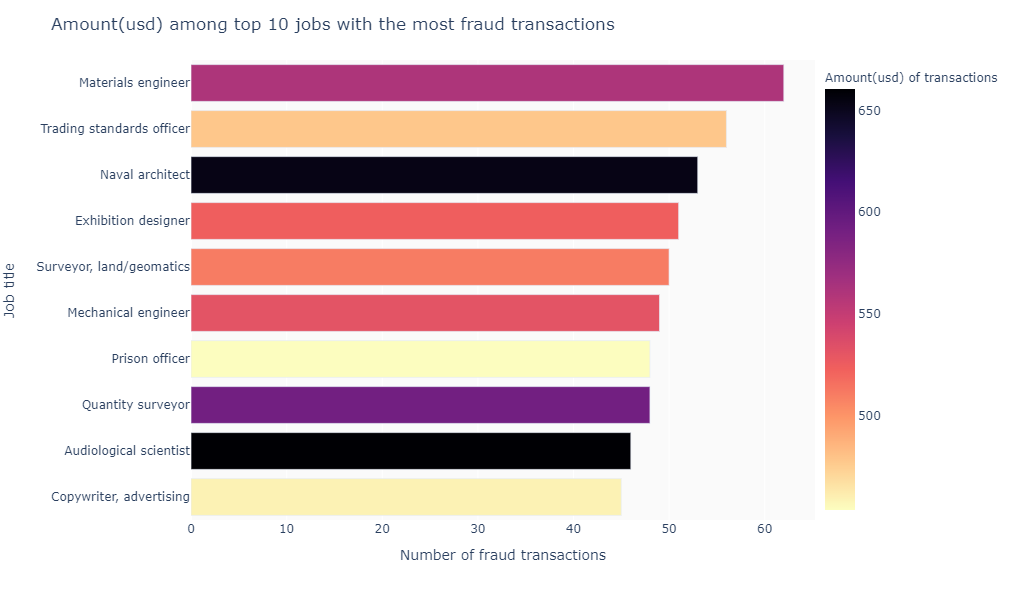

In [164]:
fig = px.bar(df_,
             y='job', x='transaction_id',
             color='amount(usd)',
             color_continuous_scale=px.colors.sequential.Magma,
             labels={'job':'Job title', 
                     'transaction_id': 'Number of fraud transactions'},
             category_orders = {"job": df_.job.values},
             width=960,
             height=600)

fig.update_layout(
    title=dict(
        text='Amount(usd) among top 10 jobs with the most fraud transactions'
    ),
    plot_bgcolor='#fafafa'
)

fig.update_coloraxes(
    colorbar=dict(
        title='Amount(usd) of transactions',
        orientation='h',
        x=1
    ),
    reversescale=True
)

fig.show()

Which credit card number/ credit card holder has most fraud transaction?

In [165]:
groups = ['credit_card_number']
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_.sort_values('transaction_id', ascending=False, inplace=True)
df_ = df_.head(10)

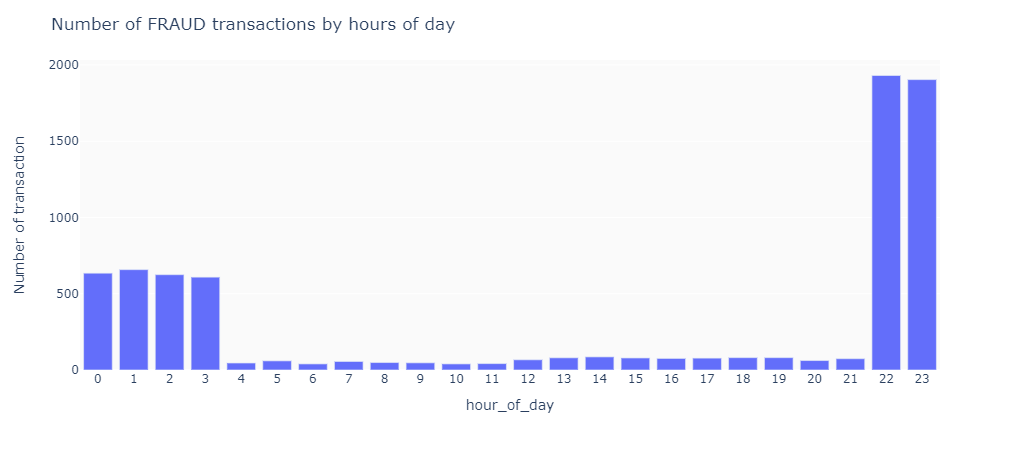

In [166]:
df_ = df_train[df_train.is_fraud==1].groupby(by='hour_of_day').agg({'transaction_id':'count'}).reset_index()

fig = px.bar(data_frame=df_,
       x='hour_of_day',
       y='transaction_id',
       labels={'transaction_id':'Number of transaction'})

fig.update_layout(
    title=dict(
        text='Number of FRAUD transactions by hours of day'
    ),
    plot_bgcolor='#fafafa'
)

fig.update_xaxes(type='category')

In [167]:
df_train.dtypes

transaction_time      datetime64[ns]
credit_card_number          category
merchant                      object
category                      object
amount(usd)                  float64
first                         object
last                          object
gender                        object
street                        object
city                          object
state                         object
zip                            int64
lat                          float64
long                         float64
city_pop                       int64
job                           object
dob                   datetime64[ns]
transaction_id                object
unix_time                      int64
merch_lat                    float64
merch_long                   float64
is_fraud                    category
time                  datetime64[ns]
hour_of_day                 category
dtype: object

<AxesSubplot:>

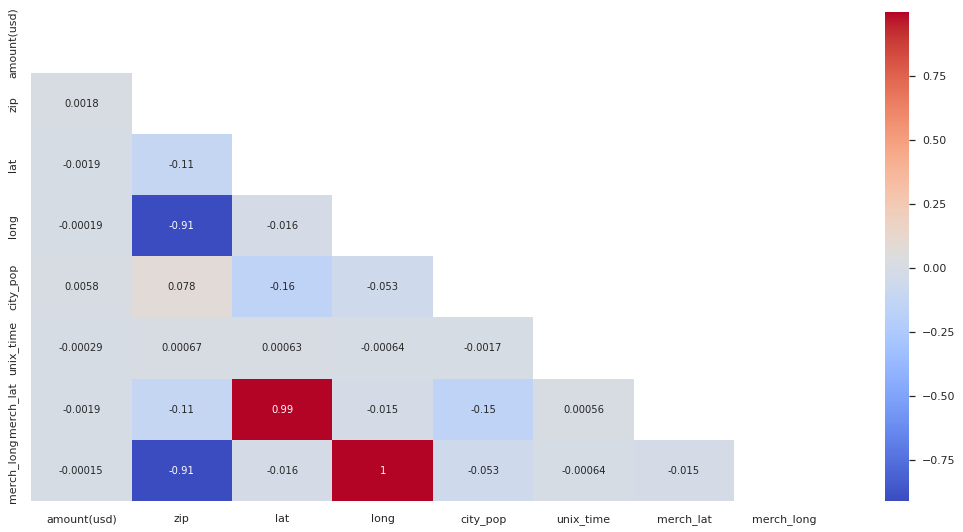

In [168]:
%matplotlib inline
fig = plt.figure(figsize=(18,9))
mask = np.triu(np.ones_like(df_train.corr()))
sns.heatmap(df_train.corr(), mask=mask, cmap='coolwarm', annot=True)

Next, build the model to predict Fraud Transactions(label "1")   
Target: The higher **F1-Score** for label 1, the better the model!

In [169]:
features = ['transaction_id', 'hour_of_day', 'category', 'amount(usd)', 'merchant', 'job']

#
X = df_train[features].set_index("transaction_id")
y = df_train['is_fraud']

print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

X shape:(1296675, 5)
y shape:(1296675,)


In [170]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(dtype=np.int64)
enc.fit(X.loc[:,['category','merchant','job']])

X.loc[:, ['category','merchant','job']] = enc.transform(X[['category','merchant','job']])

In [171]:
#X[['category','merchant','job']]

In [172]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('X_train shape:{}\ny_train shape:{}'.format(X_train.shape,y_train.shape))
print('X_test shape:{}\ny_test shape:{}'.format(X_test.shape,y_test.shape))

X_train shape:(1037340, 5)
y_train shape:(1037340,)
X_test shape:(259335, 5)
y_test shape:(259335,)


In [174]:
from sklearn.tree import DecisionTreeClassifier

dcstree = DecisionTreeClassifier(random_state=42)
dcstree.fit(X_train, y_train)

y_pred = dcstree.predict(X_test)

<AxesSubplot:>

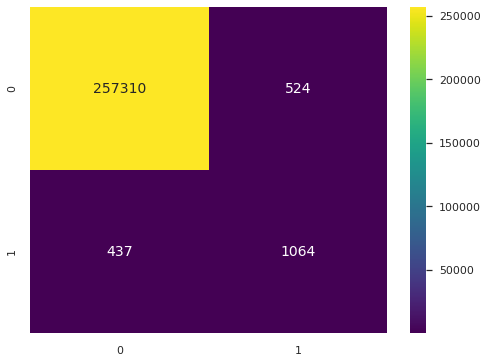

In [175]:
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cfs_matrix, cmap='viridis', annot=True, fmt='d', annot_kws=dict(fontsize=14))

In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.67      0.71      0.69      1501

    accuracy                           1.00    259335
   macro avg       0.83      0.85      0.84    259335
weighted avg       1.00      1.00      1.00    259335



With DecisionTree we have F1-Score = **0.69** for label 1 

**SMOTE**

In [177]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={1:48050}, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train.astype('float'), y_train)
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 1031335, 1: 6005})
After SMOTE: Counter({0: 1031335, 1: 48050})


In [178]:
class test_model:
    from sklearn.metrics import classification_report
    def __init__(self):
        self.metrics = ['prfs','auc','acc']

    def fit_predict(model, X_train, X_test, y_train, y_test):
        model = model
        model.fit(X_train, y_train) #Fit data to model
        y_pred = model.predict(X_test)
        return y_pred
    
    def evaluate(y_pred, metrics):
        results = {}
        for metric in metrics:
            if metric == 'prfs':
                prfs = classification_report(y_test, y_pred)
                results['prfs'] = prfs
            elif metric =='auc':
                auc_score = roc_auc_score(y_test, y_pred)
                results['auc'] = auc_score
            elif metric =='acc':
                results['acc'] = accuracy_score(y_test, y_pred)
            else:
                print('Not available metric!')
        return results

In [179]:
from sklearn.ensemble import RandomForestClassifier

# Specify your metric here
metrics = ['prfs']
print("=====================SMOTE=====================")
RDForest_eval = test_model.evaluate(y_pred=test_model.fit_predict(RandomForestClassifier(random_state=42),
                                                                  X_train_smote,
                                                                  X_test,
                                                                  y_train_smote,
                                                                  y_test
                                                                 ),
                                    metrics=metrics
                                    )

print("Random Forest model evaluate:\n", RDForest_eval['prfs'])

=====================SMOTE=====================
Random Forest model evaluate:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.79      0.74      0.76      1501

    accuracy                           1.00    259335
   macro avg       0.89      0.87      0.88    259335
weighted avg       1.00      1.00      1.00    259335



With RandomForestClassifier we have better **F1-Score = 0.76** for label 1.

Try tuning some important Hyperparameters for RDF

In [180]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

print(random_grid)

{'n_estimators': [50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [181]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score, greater_is_better=True, pos_label=1)

In [182]:
# Uncomment lines to run this code, this can be 
"""
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 50,
                               cv = 5,
                               verbose=2,
                               random_state=42
                              )

#Fit and show the best parameters
rf_random.fit(X_train, y_train)
print(rf_random.best_estimator_)
"""

'\nrf = RandomForestClassifier()\nrf_random = RandomizedSearchCV(estimator = rf,\n                               param_distributions = random_grid,\n                               n_iter = 50,\n                               cv = 5,\n                               verbose=2,\n                               random_state=42\n                              )\n\n#Fit and show the best parameters\nrf_random.fit(X_train, y_train)\nprint(rf_random.best_estimator_)\n'

The best estimator on randomized_search:  
RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [183]:
rf_random = RandomForestClassifier(max_features='sqrt',
                                   n_estimators=200,
                                   random_state=41
                                   )

rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)

# Print reprort
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.87      0.72      0.79      1501

    accuracy                           1.00    259335
   macro avg       0.93      0.86      0.89    259335
weighted avg       1.00      1.00      1.00    259335



After tuning, we have **F1-Score = 0.8** for label 1, atually good :)

In [184]:
df_test = df_test.rename(columns={"trans_date_trans_time":"transaction_time",
                         "cc_num":"credit_card_number",
                         "amt":"amount(usd)",
                         "trans_num":"transaction_id"}
                        )

# Apply function utcfromtimestamp and drop column unix_time
df_test['time'] = df_test['unix_time'].apply(datetime.utcfromtimestamp)

# Add cloumn hour of day
df_test['hour_of_day'] = df_test.time.dt.hour

df_test = df_test[features].set_index("transaction_id")
enc = OrdinalEncoder(dtype=np.int64)
enc.fit(df_test.loc[:, ['category','merchant','job']])

df_test.loc[:, ['category','merchant','job']] = enc.transform(df_test[['category','merchant','job']])

In [185]:
y_pred  = rf_random.predict(df_test)
y_proba = rf_random.predict_proba(df_test)[:, 1]

In [186]:
df_test["Fraud_Proba"] = y_proba
df_test["Fraud_Predict"] = y_pred

In [187]:
result = df_test[["Fraud_Proba", "Fraud_Predict"]]
# Store result in a CSV file 
result.to_csv(r"./PredictFraud_Result.csv")